In [22]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import time
import glob
import torch
import cc3d

from panoptica import Panoptic_Evaluator
from panoptica import MatchedInstancePair
from panoptica import NaiveThresholdMatching
from panoptica import MaximizeMergeMatching
from panoptica import Metric
from rich import print as pprint

from brats import lesion_dice
from soumya import lesion_dice_gpu
from brats_optimised import lesion_dice_gpu as lesion_dice_cpu_optimised

In [25]:
def plot(pred, gt_display):
    fig, ax = plt.subplots(1, 3, figsize=(10, 5))
    ax[0].imshow(pred[0, :, :], cmap='gray')
    ax[0].set_title('Prediction')

    ax[1].imshow(gt_display[0, :, :], cmap='gray')
    ax[1].set_title('Ground Truth')

    combined = pred + gt_display

    ax[2].imshow(combined[0, :, :], cmap='rainbow')
    ax[2].set_title('Overlay (Prediction + Ground Truth)')

    legend_elements = [Patch(facecolor='purple', edgecolor='black', label='TN'),
                    Patch(facecolor='turquoise', edgecolor='black', label='FP'),
                    Patch(facecolor='yellow', edgecolor='black', label='FN'),
                    Patch(facecolor='red', edgecolor='black', label='TP')]

    ax[2].legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1.02, 1))

    plt.show()

def score(pred, gt):
    cpu = lesion_dice(pred, gt)
    gpu = lesion_dice_gpu(pred, gt)
    gpu_optimised = lesion_dice_cpu_optimised(pred, gt)

    print(f'CPU: {cpu}')
    print(f'GPU: {gpu}')
    print(f'GPU Optimised: {gpu_optimised}')

def panop(pred, gt):

    sample = MatchedInstancePair(prediction_arr=pred, reference_arr=gt)
    evaluator = Panoptic_Evaluator(
        expected_input=MatchedInstancePair,
        decision_metric=Metric.IOU,
        decision_threshold=0.1,
    )
    result, debug_data = evaluator.evaluate(sample)
    pprint(f"{result.pq_dsc=}")

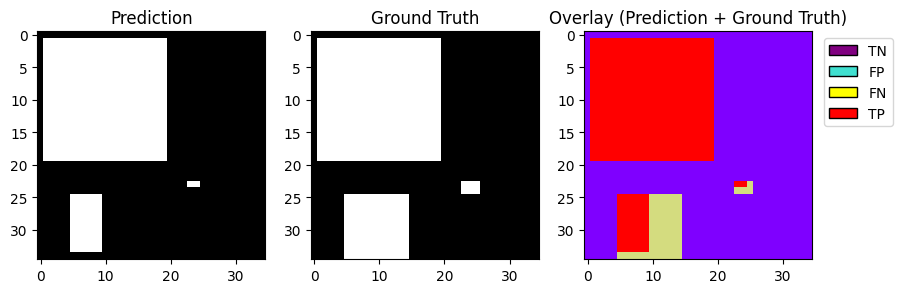

CPU: 0.7068965517241379
GPU: 0.7068965435028076
GPU Optimised: 0.7068965517241379
Panoptic: Start Evaluation
-- Got MatchedInstancePair, will evaluate instances


result.pq_dsc=0.7068965517241379

In [26]:
pred = torch.zeros((10, 35, 35))
gt   = torch.zeros((10, 35, 35))

pred[0, 1:20, 1:20] = 1
gt[0, 1:20, 1:20] = 1

pred[0, 23:24, 23:25] = 1
gt[0, 23:25, 23:26] = 1


pred[0, 25:34, 5:10] = 1
gt[0, 25:35, 5:15] = 1

plot(pred, gt*2)

score(pred, gt)

pred = pred.numpy()
gt = gt.numpy()
pred = cc3d.connected_components(pred)
gt = cc3d.connected_components(gt)
#unsigned int32
gt = gt.astype(np.uint32)
pred = pred.astype(np.uint32)
panop(pred, gt)